In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle

# Load Data

In [2]:
raw = pd.read_pickle(r'Data\results.pkl')
raw['Base_model'] = raw.apply(lambda x: x['Model'].split('_')[0], axis=1)
raw

,Avg-R,Daily-R,Weekly-R,Coverage,Data,Model,Base_model
0,0.678156,0.693189,0.663122,0.940574,Daily,AgglomerativeClustering_100,AgglomerativeClustering
1,0.683671,0.695805,0.671537,0.928279,Weekly,AgglomerativeClustering_100,AgglomerativeClustering
2,0.625419,0.636527,0.614311,0.942623,Monthly,AgglomerativeClustering_100,AgglomerativeClustering
3,0.657812,0.670607,0.645018,0.930328,Daily + Weekly,AgglomerativeClustering_100,AgglomerativeClustering
4,0.667323,0.678945,0.655701,0.922131,Daily + Monthly,AgglomerativeClustering_100,AgglomerativeClustering
...,...,...,...,...,...,...,...
415,0.467208,0.482679,0.451737,0.997925,Monthly + GICS_Sub,DBSCAN_2,DBSCAN
416,0.779797,0.784112,0.775481,0.784232,Daily + Weekly + GICS_Sub,DBSCAN_2,DBSCAN
417,0.785668,0.798901,0.772435,0.892116,Daily + Monthly + GICS_Sub,DBSCAN_2,DBSCAN
418,0.888260,0.885520,0.890999,0.941909,Weekly + Monthly + GICS_Sub,DBSCAN_2,DBSCAN


# Coverage vs Correlation

In [3]:
data = raw[raw['Data'] == 'Daily']
AgglomerativeClustering = data[data['Base_model'] == 'AgglomerativeClustering'][['Coverage','Avg-R']]
DBSCAN = data[data['Base_model'] == 'DBSCAN'][['Coverage','Avg-R']]
KMeans = data[data['Base_model'] == 'KMeans'][['Coverage','Avg-R']]
AffinityPropagation = data[data['Base_model'] == 'AffinityPropagation'][['Coverage','Avg-R']]

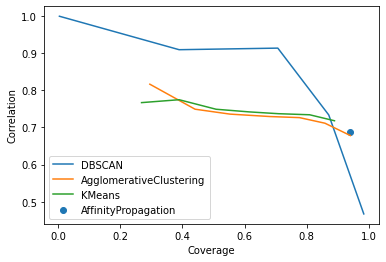

In [26]:
plt.plot(DBSCAN['Coverage'],DBSCAN['Avg-R'])
plt.plot(AgglomerativeClustering['Coverage'],AgglomerativeClustering['Avg-R'])
plt.plot(KMeans['Coverage'],KMeans['Avg-R'])
plt.scatter(AffinityPropagation['Coverage'],AffinityPropagation['Avg-R'])
plt.legend(['DBSCAN','AgglomerativeClustering','KMeans','AffinityPropagation'])
plt.ylabel('Correlation')
plt.xlabel('Coverage')
plt.show()

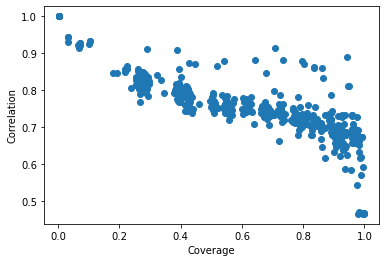

In [48]:
plt.scatter(raw['Coverage'],raw['Avg-R'])
plt.ylabel('Correlation')
plt.xlabel('Coverage')
plt.show()

# Best Correlation Per Data Set

In [5]:
maxs = raw[raw['Coverage'] > .7][['Data','Avg-R']]
maxs = maxs.groupby('Data').agg('max')
bests = pd.merge(raw,maxs,on=['Avg-R','Data'])
bests

,Avg-R,Daily-R,Weekly-R,Coverage,Data,Model,Base_model
0,0.741286,0.745847,0.736724,0.771784,Daily + GICS_Sector,AgglomerativeClustering_200,AgglomerativeClustering
1,0.735350,0.740813,0.729888,0.794606,Monthly + GICS_Sub,AgglomerativeClustering_200,AgglomerativeClustering
2,0.763041,0.768183,0.757900,0.734440,Weekly + GICS_Sector,KMeans_200,KMeans
3,0.717839,0.727028,0.708650,0.738589,Monthly + GICS_Sector,KMeans_200,KMeans
4,0.761726,0.766232,0.757219,0.719917,Weekly + Monthly + GICS_Sector,KMeans_200,KMeans
5,0.730385,0.738243,0.722527,0.959016,Monthly,DBSCAN_1,DBSCAN
6,0.913198,0.915555,0.910840,0.706967,Daily,DBSCAN_1_25,DBSCAN
7,0.860707,0.866016,0.855398,0.836066,Weekly,DBSCAN_1_25,DBSCAN
8,0.729277,0.739404,0.719150,0.724066,Weekly + GICS_Sub,DBSCAN_1_25,DBSCAN
9,0.879514,0.886190,0.872839,0.735656,Daily + Monthly,DBSCAN_1_5,DBSCAN


# Noteable Combinations

In [20]:
raw[(raw.Coverage > .7) & (raw['Avg-R'] > .9)]

,Avg-R,Daily-R,Weekly-R,Coverage,Data,Model,Base_model
357,0.913198,0.915555,0.91084,0.706967,Daily,DBSCAN_1_25,DBSCAN


In [22]:
raw[(raw.Coverage > .9) & (raw['Avg-R'] > .85)]

,Avg-R,Daily-R,Weekly-R,Coverage,Data,Model,Base_model
418,0.88826,0.88552,0.890999,0.941909,Weekly + Monthly + GICS_Sub,DBSCAN_2,DBSCAN


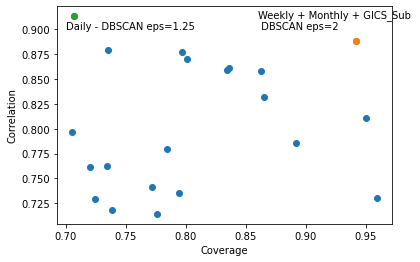

In [49]:
plt.scatter(bests['Coverage'],bests['Avg-R'])

plt.annotate('Weekly + Monthly + GICS_Sub \n DBSCAN eps=2', (0.86,0.9))
plt.scatter(0.941909,0.88826)

plt.annotate('Daily - DBSCAN eps=1.25', (0.7,0.90))
plt.scatter(0.706967,0.913198)

plt.ylabel('Correlation')
plt.xlabel('Coverage')
plt.show()